In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile
filename="/content/drive/MyDrive/ISIC-2017_Training_Data.zip"
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("done")


done


In [3]:
from zipfile import ZipFile
filename="/content/drive/MyDrive/ISIC-2017_Test_v2_Data.zip"
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("done")

done


In [4]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D,Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix

%matplotlib inline

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/ISIC-2017_Training_Part3_GroundTruth.csv')
test_df=pd.read_csv('/content/drive/MyDrive/ISIC-2017_Test_v2_Part3_GroundTruth.csv')

In [6]:
def add_jpg(x):
    x=x+".jpg"
    return x

In [7]:
train_df['new_image_id']=train_df['image_id'].apply(add_jpg)
test_df['new_image_id']=test_df['image_id'].apply(add_jpg)

In [8]:
def add_label1(x):
    if(x==0.0):
      return 'no'
    else:
      return 'mel'

In [9]:
def add_label2(x):
    if(x==0.0):
      return 'no'
    else:
      return 'seb'

In [10]:
def add_label3(x):
    if(x=='nono'):
      return 0
    elif(x=='melno'):
      return 2
    else:
      return 1

In [11]:
train_df['id']=train_df['melanoma'].apply(add_label1)+train_df['seborrheic_keratosis'].apply(add_label2)
test_df['id']=test_df['melanoma'].apply(add_label1)+test_df['seborrheic_keratosis'].apply(add_label2)

In [12]:
train_df['label']=train_df['id'].apply(add_label3)
train_df

,image_id,melanoma,seborrheic_keratosis,new_image_id,id,label
0,ISIC_0000000,0.0,0.0,ISIC_0000000.jpg,nono,0
1,ISIC_0000001,0.0,0.0,ISIC_0000001.jpg,nono,0
2,ISIC_0000002,1.0,0.0,ISIC_0000002.jpg,melno,2
3,ISIC_0000003,0.0,0.0,ISIC_0000003.jpg,nono,0
4,ISIC_0000004,1.0,0.0,ISIC_0000004.jpg,melno,2
...,...,...,...,...,...,...
1995,ISIC_0015220,0.0,1.0,ISIC_0015220.jpg,noseb,1
1996,ISIC_0015233,0.0,1.0,ISIC_0015233.jpg,noseb,1
1997,ISIC_0015260,0.0,1.0,ISIC_0015260.jpg,noseb,1
1998,ISIC_0015284,1.0,0.0,ISIC_0015284.jpg,melno,2


In [13]:
train_df=train_df[train_df.label != 2]
train_df

,image_id,melanoma,seborrheic_keratosis,new_image_id,id,label
0,ISIC_0000000,0.0,0.0,ISIC_0000000.jpg,nono,0
1,ISIC_0000001,0.0,0.0,ISIC_0000001.jpg,nono,0
3,ISIC_0000003,0.0,0.0,ISIC_0000003.jpg,nono,0
5,ISIC_0000006,0.0,0.0,ISIC_0000006.jpg,nono,0
6,ISIC_0000007,0.0,0.0,ISIC_0000007.jpg,nono,0
...,...,...,...,...,...,...
1989,ISIC_0015182,0.0,1.0,ISIC_0015182.jpg,noseb,1
1995,ISIC_0015220,0.0,1.0,ISIC_0015220.jpg,noseb,1
1996,ISIC_0015233,0.0,1.0,ISIC_0015233.jpg,noseb,1
1997,ISIC_0015260,0.0,1.0,ISIC_0015260.jpg,noseb,1


In [14]:
test_df['label']=test_df['id'].apply(add_label3)
test_df=test_df[test_df.label != 2]

In [15]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout


%matplotlib inline

In [16]:
main_path = "/content/ISIC-2017_Training_Data"
img_array = cv2.imread('/content/ISIC-2017_Training_Data/ISIC_0000000.jpg') 
img_array.shape

(767, 1022, 3)

In [17]:

imagedict={}
def add_image1(x,y):
    main_path = "/content/ISIC-2017_Training_Data"
    if x in os.listdir(main_path):  # iterate over each image 
        img_array = cv2.imread(os.path.join(main_path,x))  # convert to array
        image=(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        image = (cv2.resize(image, (224, 224)))  # resize to normalize data size
        image=np.array(image)
        image = image.astype('float32')/255
        if y in imagedict:
          imagedict[y].append(image)
        else:
          imagedict[y]=[image]
    return 

In [18]:
train_df.apply(lambda x: add_image1(x['new_image_id'], x['label']), axis=1)
train_df.head()

,image_id,melanoma,seborrheic_keratosis,new_image_id,id,label
0,ISIC_0000000,0.0,0.0,ISIC_0000000.jpg,nono,0
1,ISIC_0000001,0.0,0.0,ISIC_0000001.jpg,nono,0
3,ISIC_0000003,0.0,0.0,ISIC_0000003.jpg,nono,0
5,ISIC_0000006,0.0,0.0,ISIC_0000006.jpg,nono,0
6,ISIC_0000007,0.0,0.0,ISIC_0000007.jpg,nono,0


In [19]:

test_df[test_df.label==1]

,image_id,melanoma,seborrheic_keratosis,new_image_id,id,label
0,ISIC_0012086,0.0,1.0,ISIC_0012086.jpg,noseb,1
3,ISIC_0012134,0.0,1.0,ISIC_0012134.jpg,noseb,1
4,ISIC_0012136,0.0,1.0,ISIC_0012136.jpg,noseb,1
8,ISIC_0012178,0.0,1.0,ISIC_0012178.jpg,noseb,1
9,ISIC_0012199,0.0,1.0,ISIC_0012199.jpg,noseb,1
...,...,...,...,...,...,...
214,ISIC_0014647,0.0,1.0,ISIC_0014647.jpg,noseb,1
215,ISIC_0014648,0.0,1.0,ISIC_0014648.jpg,noseb,1
216,ISIC_0014649,0.0,1.0,ISIC_0014649.jpg,noseb,1
217,ISIC_0014652,0.0,1.0,ISIC_0014652.jpg,noseb,1


In [20]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
          rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
        )



for key in imagedict.keys():
  directory = os.path.join(f'./{key}')
  if not os.path.exists(directory):
    os.mkdir(directory)
  imagedict[key]=np.array(imagedict[key])
  imagedict[key]=imagedict[key].reshape(imagedict[key].shape[0], 224, 224, 3)
  image_gen = data_gen.flow(imagedict[key], batch_size=1, save_to_dir=f'./{key}',
                          save_prefix='image', save_format='jpg')
  print(len(imagedict[key]))
  total = 0
  for _image in image_gen:
      total += 1
      if total >= 5000:
          break


1372
254


In [21]:
imagedict={}

In [22]:
os.mkdir('balanced_data')
!mv /content/0 /content/balanced_data
!mv /content/1 /content/balanced_data


In [23]:
test_list = list(test_df['new_image_id'])

In [24]:
os.mkdir('test_dir')

In [25]:
for i in range(2):
    directory='test_dir'+'/'+str(i)
    os.mkdir(directory)


In [26]:
test_df.set_index('new_image_id', inplace=True)

In [27]:
import shutil
for image in test_list:

    # Set all file names as name + jpeg extension.
    file_name = image
    label = test_df.loc[image, 'label']

    # destination path to image
    source = os.path.join('/content/ISIC-2017_Test_v2_Data/', file_name)

    # copy the image from the source to the destination
    dest = os.path.join('test_dir/', str(label), file_name)

    shutil.copyfile(source, dest)

In [28]:

# BUILD MODEL
# '''

train_path = '/content/balanced_data'
validation_path = '/content/test_dir'

train_samples = len(train_df)
validation_samples = len(test_df)

train_batch_size = 10
validation_batch_size = 10
image_size = 224

# Divide total # of samples by batch size to section off training samples into steps.
# Then round up with np.ceil function.
train_steps = np.ceil(train_samples // train_batch_size)
val_steps = np.ceil(validation_samples // validation_batch_size)
print(val_steps)
# Create an Image Data Generator to input later into our model.
datagen= tf.keras.preprocessing.image.ImageDataGenerator(
    # Use Inception ResNet v2
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input
)


### GETTING BATCHES FROM DIRECTORY PATHS ###
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                                    target_size=(224, 224),
                                                    batch_size=train_batch_size,
                                                    shuffle=True
                                                    )


print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(directory=validation_path,
                                           target_size=(224, 224),
                                           batch_size=1,
                                           shuffle=False
                                           )





48.0

Train Batches: 
Found 9996 images belonging to 2 classes.

Test Batches: 
Found 483 images belonging to 2 classes.


In [29]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()
 

In [30]:

resnet = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classifier_activation="softmax",

)

# Exclude the last 28 layers of the model.
conv = resnet.layers[-228].output


219062272/219055592 [==============================] - 2s 0us/step


Soft Attention

In [31]:


attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)


INCEPTION RESNET A

In [32]:
def inceptionA(input_value):  
    conv1 = Conv2D(filters=32,padding='same',kernel_size=(1,1),activation='relu')(input_value)
    conv1 = BatchNormalization()(conv1)
    
    conv2 = Conv2D(filters=32,padding='same',kernel_size=(1,1),activation='relu')(input_value)
    conv2  = Conv2D(filters=32,padding='same',kernel_size=(3,3),activation='relu')(conv2 )
    conv2  = BatchNormalization()(conv2)
    
    conv3 = Conv2D(filters=32,padding='same',kernel_size=(1,1),activation='relu')(input_value)
    conv3 = Conv2D(filters=32,padding='same',kernel_size=(3,3),activation='relu')(conv3)
    conv3= Conv2D(filters=32,padding='same',kernel_size=(3,3),activation='relu')(conv3)
    conv3= BatchNormalization()(conv3)
    
    concat= concatenate([conv1,conv2,conv3])

    conv = Conv2D(filters=int(input_value.shape[-1]),padding='same',kernel_size=1,activation='relu')(concat)
    conv = BatchNormalization()(conv)
    conv = add([conv,input_value])
    conv = Conv2D(filters=256,padding='same',kernel_size=1,strides=1,activation='relu')(conv)
    return conv

INCEPTION RESNET B

In [33]:
def inceptionB(input_value):  
    conv1 = Conv2D(filters=128,padding='same',kernel_size=(1,1),activation='relu')(input_value)
    conv1 = BatchNormalization()(conv1)
    
    conv2 = Conv2D(filters=128,padding='same',kernel_size=(1,1),activation='relu')(input_value)
    conv2  = Conv2D(filters=128,padding='same',kernel_size=(5,1),activation='relu')(conv2 )
    conv2  = Conv2D(filters=128,padding='same',kernel_size=(1,5),activation='relu')(conv2 )
    conv2  = BatchNormalization()(conv2)
        
    concat= concatenate([conv1,conv2])

    conv = Conv2D(filters=int(input_value.shape[-1]),padding='same',kernel_size=1,activation='relu')(concat)
    conv = BatchNormalization()(conv)
    conv = add([conv,input_value])
    conv = Conv2D(filters=512,padding='same',kernel_size=1,strides=1,activation='relu')(conv)
    return conv

INCEPTION RESNET C

In [34]:
def inceptionC(input_value):  
    conv1 = Conv2D(filters=192,padding='same',kernel_size=(1,1),activation='relu')(input_value)
    conv1 = BatchNormalization()(conv1)
    
    conv2 = Conv2D(filters=192,padding='same',kernel_size=(1,1),activation='relu')(input_value)
    conv2  = Conv2D(filters=192,padding='same',kernel_size=(3,1),activation='relu')(conv2 )
    conv2  = Conv2D(filters=192,padding='same',kernel_size=(1,3),activation='relu')(conv2 )
    conv2  = BatchNormalization()(conv2)
        
    concat= concatenate([conv1,conv2])

    conv = Conv2D(filters=int(input_value.shape[-1]),padding='same',kernel_size=1,activation='relu')(concat)
    conv = BatchNormalization()(conv)
    conv = add([conv,input_value])
    conv = Conv2D(filters=1024,padding='same',kernel_size=1,strides=1,activation='relu')(conv)
    return conv

Reduction A

In [35]:
def reductionA(input_value):
    conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2), padding='same')(input_value)
    
    conv2 = Conv2D(filters=384,padding='same',kernel_size=(3,3),strides=(2,2),activation='relu')(input_value)
    conv2 = BatchNormalization()(conv2)
    
    conv3 = Conv2D(filters=256,padding='same',kernel_size=(1,1),strides=(1,1),activation='relu')(input_value)
    conv3 = Conv2D(filters=256,padding='same',kernel_size=(3,3),strides=(1,1),activation='relu')(conv3)
    conv3 = Conv2D(filters=384,padding='same',kernel_size=(3,3),strides=(2,2),activation='relu')(conv3)
    conv3= BatchNormalization()(conv3)
    
    attention_layer,map = SoftAttention(aggregate=True,m=32,concat_with_x=False,ch=int(input_value.shape[-1]),name='soft_attention_2')(input_value)
    attention_layer= MaxPooling2D(pool_size=(2,2), padding='same')(attention_layer)
    
    conv = concatenate([conv1,conv2,conv3,attention_layer])
    conv = Activation('relu')(conv)
    conv= Dropout(0.2)(conv)
    return conv

Reduction B

In [36]:
def reductionB(input_value):
    conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2), padding='same')(input_value)
    
    conv2 = Conv2D(filters=256,padding='same',kernel_size=(1,1),strides=(1,1),activation='relu')(input_value)
    conv2 = Conv2D(filters=384,padding='same',kernel_size=(3,3),strides=(2,2),activation='relu')(conv2)
    conv2 = BatchNormalization()(conv2)
    
    conv3 = Conv2D(filters=256,padding='same',kernel_size=(1,1),strides=(1,1),activation='relu')(input_value)
    conv3 = Conv2D(filters=256,padding='same',kernel_size=(3,3),strides=(2,2),activation='relu')(conv3)
    conv3= BatchNormalization()(conv3)

    conv4 = Conv2D(filters=256,padding='same',kernel_size=(1,1),strides=(1,1),activation='relu')(input_value)
    conv4 = Conv2D(filters=256,padding='same',kernel_size=(3,3),strides=(1,1),activation='relu')(conv4)
    conv4 = Conv2D(filters=256,padding='same',kernel_size=(3,3),strides=(2,2),activation='relu')(conv4)
    conv4= BatchNormalization()(conv4)
    
    attention_layer,map = SoftAttention(aggregate=True,m=32,concat_with_x=False,ch=int(input_value.shape[-1]),name='soft_attention_3')(input_value)
    attention_layer= MaxPooling2D(pool_size=(2,2), padding='same')(attention_layer)
    
    conv = concatenate([conv1,conv2,conv3,conv4,attention_layer])
    conv = Activation('relu')(conv)
    conv= Dropout(0.2)(conv)
    return conv



Inception Net

In [37]:
block5=inceptionC(conv)
for i in range(5):
  block5=inceptionC(block5)

In [38]:
output = GlobalAveragePooling2D()(block5)
output = Dense(2, activation='softmax')(output)
model = Model(inputs=resnet.input, outputs=output)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [40]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])


In [56]:


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)
checkpoint=  ModelCheckpoint(filepath = "seborrheic_keratosis__classification_IRV2+SA_12x12.hdf5",monitor="val_accuracy",save_best_only=True,save_weights_only=True)

callbacks_list = [checkpoint]

class_weights={0: 1, 1: 1}

print("Training model. . .")

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=15, min_delta=0.001)
history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    epochs=50,
                    verbose=2,
                    validation_data=test_batches,validation_steps=len(test_df),callbacks=[checkpoint])




Training model. . .
Epoch 1/50
162/162 - 181s - loss: 0.2185 - accuracy: 0.9154 - val_loss: 0.5057 - val_accuracy: 0.7598
Epoch 2/50
162/162 - 181s - loss: 0.2207 - accuracy: 0.9179 - val_loss: 0.3996 - val_accuracy: 0.8116
Epoch 3/50
162/162 - 183s - loss: 0.1759 - accuracy: 0.9302 - val_loss: 2.8773 - val_accuracy: 0.4472
Epoch 4/50
162/162 - 186s - loss: 0.1877 - accuracy: 0.9321 - val_loss: 0.5644 - val_accuracy: 0.8075
Epoch 5/50
162/162 - 184s - loss: 0.1987 - accuracy: 0.9235 - val_loss: 0.6805 - val_accuracy: 0.7723
Epoch 6/50
162/162 - 187s - loss: 0.1848 - accuracy: 0.9395 - val_loss: 0.5174 - val_accuracy: 0.7226
Epoch 7/50
162/162 - 185s - loss: 0.1451 - accuracy: 0.9525 - val_loss: 1.4330 - val_accuracy: 0.6190
Epoch 8/50
162/162 - 184s - loss: 0.1636 - accuracy: 0.9426 - val_loss: 0.3445 - val_accuracy: 0.8799
Epoch 9/50
162/162 - 183s - loss: 0.1567 - accuracy: 0.9401 - val_loss: 0.8990 - val_accuracy: 0.7371
Epoch 10/50
162/162 - 184s - loss: 0.1753 - accuracy: 0.9395 -

In [57]:
from tensorflow.keras import models
model.load_weights("seborrheic_keratosis__classification_IRV2+SA_12x12.hdf5")

In [58]:
predictions = model.predict(test_batches, steps=len(test_df), verbose=1)

483/483 [==============================] - 168s 348ms/step


In [59]:

y_pred = np.argmax(predictions, axis=1)
targetnames = ['benign','seb']
# Get the labels of the test images.
y_true = test_batches.classes
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Create classification report with matrix labels and target names.
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.95      0.93      0.94       393
         seb       0.71      0.77      0.74        90

    accuracy                           0.90       483
   macro avg       0.83      0.85      0.84       483
weighted avg       0.90      0.90      0.90       483



In [60]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))



Precision: 0.9019457340396626
Recall: 0.8985507246376812


In [61]:
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,average='weighted')))

weighted Roc score: 0.9351710489115069


In [62]:

pos_probs = predictions[:, 1]
roc_auc = roc_auc_score(y_true, pos_probs)
print('Logistic ROC AUC %.3f' % roc_auc)

Logistic ROC AUC 0.935


In [63]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

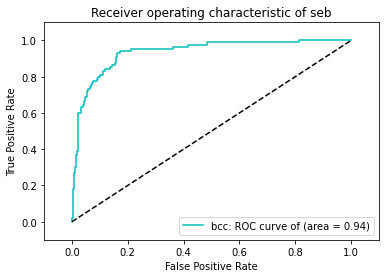

In [64]:


plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()

In [71]:
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_true,y_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[1,0])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,1]+cm1[0,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[365  28]
 [ 21  69]]
Accuracy :  0.8985507246376812
Sensitivity :  0.9455958549222798
Specificity :  0.711340206185567


In [66]:
x_test,y_test=next(test_batches)

In [67]:
sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
sa_features, sa_maps = sa_model.predict(x_test)
sa_maps.shape

(1, 16, 12, 12)

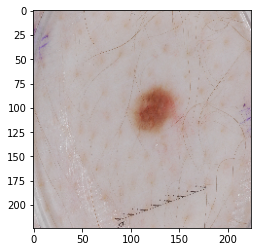

In [68]:
img_idx = 0
t = (x_test + 1)/2 # bring the range between 0,1 from -1,1
plt.imshow(t[img_idx])

In [69]:
sum_attnmap = sa_maps[img_idx]
sum_attnmap.shape

(16, 12, 12)

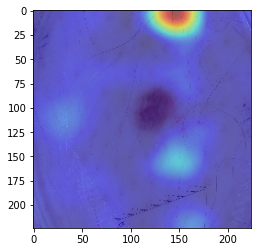

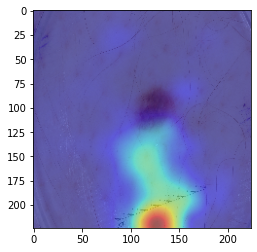

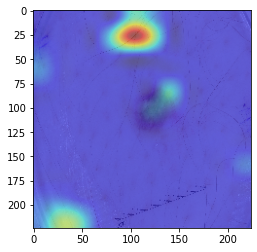

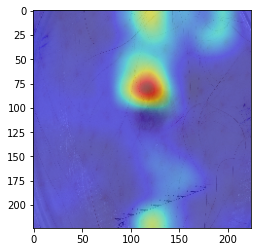

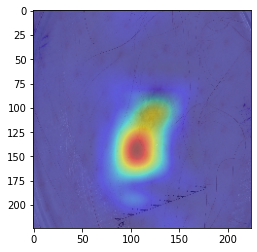

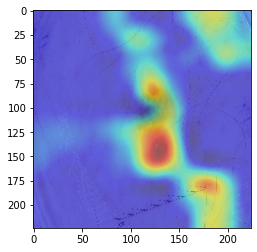

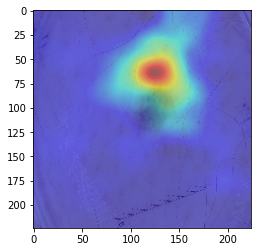

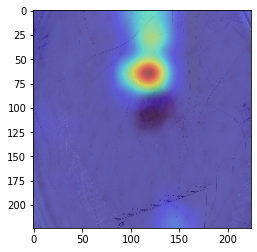

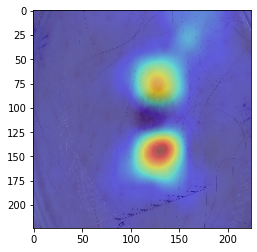

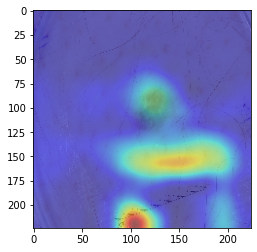

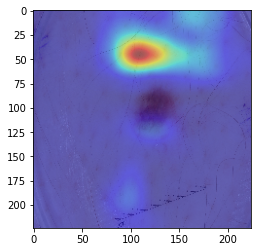

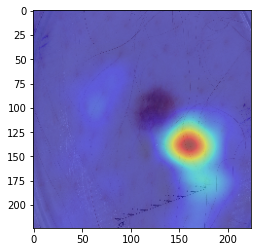

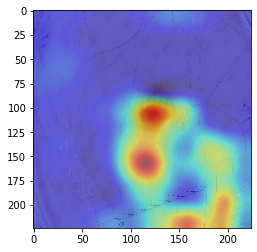

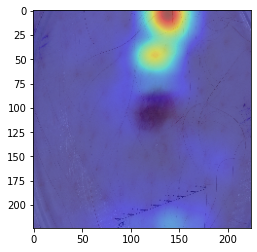

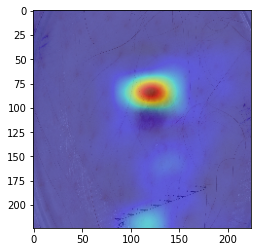

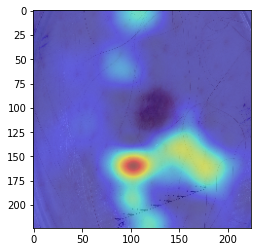

In [70]:
for i in range(16):
  plt.imshow(t[img_idx],alpha=1.0)
  plt.imshow(cv2.resize(sum_attnmap[i],(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
  plt.show()